In [2]:
%matplotlib inline

import xarray as xa
import netCDF4 as nc
import pandas as pd
import numpy as np
import urllib
import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.dates import YearLocator, WeekdayLocator, MonthLocator, DayLocator, HourLocator, DateFormatter
import matplotlib.ticker as ticker

import cmocean

/Volumes/WDC_internal/Users/bell/anaconda2/lib/python2.7/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [14]:
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['ps.fonttype'] = 42 #truetype/type2 fonts instead of type3
mpl.rcParams['pdf.fonttype'] = 42 #truetype/type2 fonts instead of type3
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.edgecolor'] = 'white'
mpl.rcParams['axes.linewidth'] = 0.25
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['xtick.major.size'] = 2
mpl.rcParams['xtick.minor.size'] = 1
mpl.rcParams['xtick.major.width'] = 0.25
mpl.rcParams['xtick.minor.width'] = 0.25
mpl.rcParams['ytick.major.size'] = 2
mpl.rcParams['ytick.minor.size'] = 1
mpl.rcParams['xtick.major.width'] = 0.25
mpl.rcParams['xtick.minor.width'] = 0.25
mpl.rcParams['ytick.direction'] = 'out'
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.color'] = 'grey'
mpl.rcParams['xtick.color'] = 'grey'

The following cell loads the dataset from an ERDDAP server.  It can be accessed like a opendap/thredds server for netcdf, but sends the data in a **streaming** format which is hard to figure out how to parse.  So instead, download a temporary file specifying the parameters in the url. 

Alternatives would be to access streaming version of csv file or other filetype from ERDDAP Server and process via pandas

In [28]:
### using code from https://ioos.github.io/notebooks_demos/notebooks/2017-03-21-ERDDAP_IOOS_Sensor_Map/
import requests
try:
    from urllib.parse import urlencode
except ImportError:
    from urllib import urlencode

def encode_erddap(urlbase, fname, columns, params):
    """
    urlbase: the base string for the endpoint
             (e.g.: https://erddap.axiomdatascience.com/erddap/tabledap).
    fname: the data source (e.g.: `sensor_service`) and the response (e.g.: `.csvp` for CSV).
    columns: the columns of the return table.
    params: the parameters for the query.

    Returns a valid ERDDAP endpoint.
    """
    urlbase = urlbase.rstrip('/')
    if not urlbase.lower().startswith(('http:', 'https:')):
        msg = 'Expected valid URL but got {}'.format
        raise ValueError(msg(urlbase))

    columns = ','.join(columns)
    params = urlencode(params)
    endpoint = '{urlbase}/{fname}?{columns}&{params}'.format

    url = endpoint(urlbase=urlbase, fname=fname,
                   columns=columns, params=params)
    r = requests.get(url)
    r.raise_for_status()
    return url

In [33]:
try:
    from urllib.parse import unquote
except ImportError:
    from urllib2 import unquote

    # return profile for float id
def get_profile(profileid,starttime,endtime):
    
    urlbase = 'http://krafla.pmel.noaa.gov:8080/erddap/tabledap/'

    fname = 'sg401_b9ae_ed68_1861.csvp'

    columns = ('profileid',
               'time',
               'latitude',
               'longitude',
               'temperature',
               'salinity',
               'depth')
    params = {
        # Inequalities do not exist in HTTP parameters,
        # so we need to hardcode the `>` in the time key to get a '>='.
        # Note that a '>' or '<' cannot be encoded with `urlencode`, only `>=` and `<=`.
        'time>': starttime+'T00:00:00Z',
        'time<': endtime+'T00:00:00Z',
        'profileid': profileid
    }

    url = encode_erddap(urlbase, fname, columns, params)

    df = pd.read_csv(url, index_col=0, parse_dates=['time (UTC)'])
    
    return df



In [35]:
p_df = get_profile('"p4010010"','2017-06-01','2017-12-01')


In [21]:
#each profile is actually a combination of a downcast and an upcast - split them at the maximum pressure

def castdirection(depth):
    """determin index of upcast and downcast"""
    downcast = [0,np.argmax(depth)]
    upcast = [np.argmax(depth),len(depth)]

    return (downcast,upcast)


In [36]:
p_df

,time (UTC),latitude (degrees_north),longitude (degrees_east),temperature (degrees_Celsius),salinity (PSU),depth (m)
profileid,,,,,,
p4010010,2017-07-26 20:52:20,59.279948,-170.425390,9.428163,NaN,1.106780
p4010010,2017-07-26 20:52:33,59.279949,-170.425379,9.467621,NaN,0.757796
p4010010,2017-07-26 20:52:41,59.279950,-170.425360,9.518107,NaN,0.229333
p4010010,2017-07-26 20:52:52,59.279953,-170.425361,9.578051,31.524196,0.418782
p4010010,2017-07-26 20:52:59,59.279959,-170.425375,9.491614,31.577367,0.927303
p4010010,2017-07-26 20:53:05,59.279964,-170.425385,9.387139,31.600208,1.425851
p4010010,2017-07-26 20:53:12,59.279970,-170.425394,9.356095,31.585461,1.964281
p4010010,2017-07-26 20:53:18,59.279976,-170.425402,9.350869,31.584361,2.502710
p4010010,2017-07-26 20:53:28,59.279984,-170.425413,9.334445,31.590233,3.410059


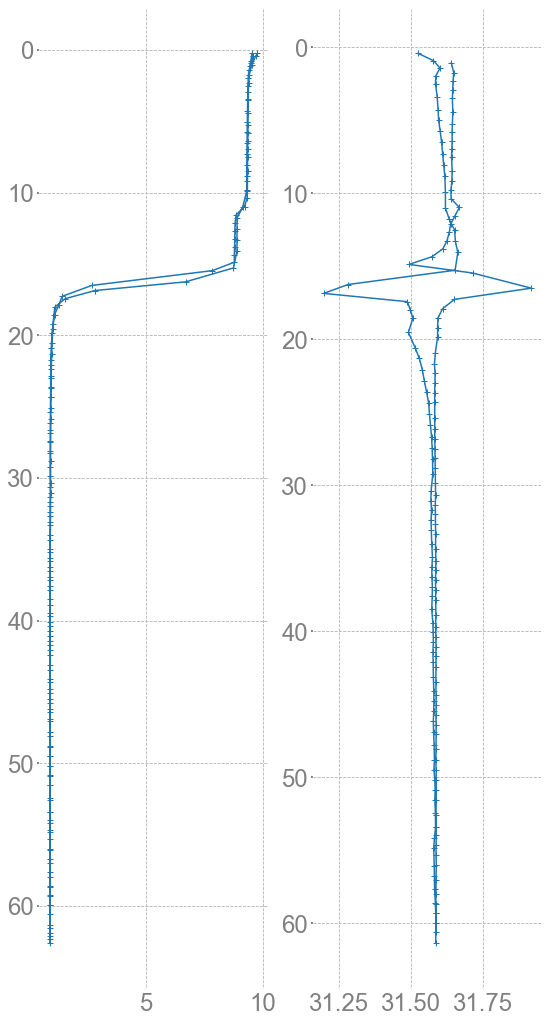

In [58]:
cmap = cmocean.cm.thermal
plt.figure(1, figsize=(9,18), facecolor='w', edgecolor='w')
ax1 = plt.subplot(1,2,1)
p1 = ax1.plot(p_df['temperature (degrees_Celsius)'],p_df['depth (m)'],'-+')
ax1.invert_yaxis()
ax1 = plt.subplot(1,2,2)
p1 = ax1.plot(p_df['salinity (PSU)'],p_df['depth (m)'],'-+')
ax1.invert_yaxis()